In [1]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'


print('Selected device:', device)

Selected device: cuda


In [2]:
import pandas as pd

''' Load Tokens from CSV '''
# df = pd.read_parquet('../data-sets/train-00000-of-00001 - 2025-11-01.parquet')
df = pd.read_parquet('../data-sets/Zinparen in Engels-Nederlands - 2025-11-01.parquet')


df

,ENG_TOKENS,NLD_TOKENS
0,"[<sos>, Let, 's, try, something, ., <eos>]","[<sos>, Laten, we, iets, proberen, !, <eos>]"
1,"[<sos>, Let, 's, try, something, ., <eos>]","[<sos>, Laat, ons, iets, proberen, ., <eos>]"
2,"[<sos>, I, have, to, go, to, sleep, ., <eos>]","[<sos>, Ik, moet, gaan, slapen, ., <eos>]"
3,"[<sos>, Today, is, June, 18th, and, it, is, Mu...","[<sos>, Vandaag, is, het, 18, juni, en, het, i..."
4,"[<sos>, Muiriel, is, 20, now, ., <eos>]","[<sos>, Muiriel, is, nu, 20, jaar, oud, ., <eos>]"
...,...,...
155192,"[<sos>, Cotton, candy, is, usually, sold, and,...","[<sos>, Suikerspinnen, worden, gewoonlijk, ver..."
155193,"[<sos>, At, the, moment, I, am, looking, for, ...","[<sos>, Op, het, moment, ben, ik, op, zoek, na..."
155194,"[<sos>, The, unthinkable, happened, ., <eos>]","[<sos>, Het, ondenkbare, is, gebeurd, ., <eos>]"
155195,"[<sos>, Let, 's, wait, until, she, rings, ., <...","[<sos>, Laten, we, wachten, tot, ze, belt, !, ..."


In [3]:
TRAIN_SPLIT = 0.9
MAX_SIZE = 20
FORBIDDEN_CHARS = ['€', '$', '[', ']', '-', '(', ')']

''' Filtering '''
def filter(row):	
	if (len(row['ENG_TOKENS']) > MAX_SIZE):
		return False
    
	if (len(row['NLD_TOKENS']) > MAX_SIZE):
		return False

	for token in row['ENG_TOKENS']:
		if any(c in token for c in FORBIDDEN_CHARS):
			return False
	
	for token in row['NLD_TOKENS']:
		if any(c in token for c in FORBIDDEN_CHARS):
			return False

	return True

df = df[df.apply(filter, axis=1)]

''' Splitting Training and Validation Data '''
df = df.sample(frac=1).reset_index(drop=True)
split = int(TRAIN_SPLIT * len(df))

train_data = df.iloc[:split, :]
test_data  = df.iloc[split:, :]
test_data.reset_index(drop=True, inplace=True)


print('Valid rows from file:', len(df))
print('Rows for train data:', len(train_data))
train_data

Valid rows from file: 151351
Rows for train data: 136215


,ENG_TOKENS,NLD_TOKENS
0,"[<sos>, His, parents, love, me, ., <eos>]","[<sos>, Zijn, ouders, houden, van, me, ., <eos>]"
1,"[<sos>, I, 've, forgotten, the, answer, again,...","[<sos>, Helaas, ben, ik, het, antwoord, verget..."
2,"[<sos>, I, do, n't, dare, to, fall, asleep, .,...","[<sos>, Ik, durf, niet, in, slaap, te, vallen,..."
3,"[<sos>, Tom, will, move, back, to, Australia, ...","[<sos>, Tom, verhuist, terug, naar, Australië,..."
4,"[<sos>, Everything, popular, is, wrong, ., <eos>]","[<sos>, Al, wat, populair, is, ,, is, verkeerd..."
...,...,...
136210,"[<sos>, What, year, is, it, ?, <eos>]","[<sos>, Welk, jaar, is, het, ?, <eos>]"
136211,"[<sos>, Why, did, she, quit, ?, <eos>]","[<sos>, Waarom, stopte, ze, ?, <eos>]"
136212,"[<sos>, Mennad, helped, Baya, be, strong, ., <...","[<sos>, Mennad, hielp, Baya, met, sterk, zijn,..."
136213,"[<sos>, You, must, learn, from, your, mistakes...","[<sos>, Je, moet, leren, van, je, eigen, foute..."


In [4]:
PAD_token = '<pad>'
SOS_token = '<sos>'
EOS_token = '<eos>'
UNK_token = '<unk>'
special_tokens = [PAD_token, SOS_token, EOS_token, UNK_token]

min_size = 5

class Vocabulary():

	def __init__(self):
		self.num_tokens = 0
		self.token2index = {}
		self.index2token = {}
		self.token2count = {}
		
		for token in special_tokens:
			self.add_token(token)

	def add_token(self, token):
		if token not in self.token2index:
			ix = self.num_tokens

			self.token2index[token] = ix
			self.index2token[ix] = token
			self.token2count[token] = 1
			self.num_tokens += 1
		else:
			self.token2count[token] += 1
	
	def limit(self):
		valid_tokens = [
			t for t, c in self.token2count.items()
			if c >= min_size or t in special_tokens
		]

		self.token2index.clear()
		self.index2token.clear()
		self.num_tokens = 0
		
		for token in special_tokens:
			self.token2index[token] = self.num_tokens
			self.index2token[self.num_tokens] = token
			self.num_tokens += 1

		for token in valid_tokens:
			if token not in special_tokens:
				self.token2index[token] = self.num_tokens
				self.index2token[self.num_tokens] = token
				self.num_tokens += 1

		self.token2count = {t: self.token2count[t] for t in valid_tokens}
	
	def lookup_indices(self, tokens):
		return [self[token] for token in tokens]
	
	def lookup_tokens(self, indices):
		return [self.index2token.get(ix, UNK_token) for ix in indices]

	def __len__(self):
		return self.num_tokens

	def __getitem__(self, key):
		return self.token2index.get(key, self.token2index[UNK_token])

	@staticmethod
	def from_dataframe(df, column):
		vocab = Vocabulary()
		for tokens in df[column]:
			for token in tokens.tolist():
				vocab.add_token(token)
		
		vocab.limit()
		return vocab


eng_vocab = Vocabulary.from_dataframe(train_data, "ENG_TOKENS")
nld_vocab = Vocabulary.from_dataframe(train_data, "NLD_TOKENS")


print('size of english vocab:', len(eng_vocab))
print('size of dutch vocat:', len(nld_vocab))

sorted(eng_vocab.token2count.items(), key=lambda x: x[1], reverse=True)[:25]

size of english vocab: 6715
size of dutch vocat: 7651


[('<sos>', 136216),
 ('<eos>', 136216),
 ('.', 111201),
 ('I', 34713),
 ('?', 22358),
 ('to', 22150),
 ('the', 21436),
 ('Tom', 21143),
 ('you', 20347),
 ('is', 19147),
 ('a', 18678),
 ("n't", 14528),
 ("'s", 10489),
 ('in', 9389),
 ('that', 9339),
 ('do', 8883),
 (',', 8053),
 ('of', 7822),
 ('was', 7555),
 ('The', 6660),
 ('have', 6502),
 ('He', 6477),
 ('You', 5619),
 ('me', 5617),
 ('are', 5480)]

In [5]:
import numpy as np

eng_pad_index = eng_vocab[PAD_token]
nld_pad_index = nld_vocab[PAD_token]


''' Vectorize the data '''
def build_dataset(df):
    X = []
    Y = []

    for tokens in df['ENG_TOKENS']:
        ixs = eng_vocab.lookup_indices(tokens)
        if len(ixs) < MAX_SIZE:
            ixs = ixs + [eng_pad_index] * (MAX_SIZE - len(ixs))
        else:
            ixs = ixs[:MAX_SIZE]
        X.append(ixs)

    for tokens in df['NLD_TOKENS']:
        ixs = nld_vocab.lookup_indices(tokens)
        if len(ixs) < MAX_SIZE:
            ixs = ixs + [nld_pad_index] * (MAX_SIZE - len(ixs))
        else:
            ixs = ixs[:MAX_SIZE]
        Y.append(ixs)
    
    X = torch.tensor(np.array(X), dtype=torch.long)
    Y = torch.tensor(np.array(Y), dtype=torch.long)
    return X, Y


Xtr, Ytr = build_dataset(train_data)
Xte, Yte = build_dataset(test_data)

print('Xtr shape:', Xtr.shape)

Xtr shape: torch.Size([136215, 20])


In [6]:
import random

print('Random vector:')
ix = random.randint(0, len(Xtr))
print(Xtr[ix].tolist())
print(Ytr[ix].tolist())
print()
print(eng_vocab.lookup_tokens(Xtr[ix].tolist()))
print(nld_vocab.lookup_tokens(Ytr[ix].tolist()))

Random vector:
[1, 192, 204, 4532, 1507, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 70, 3, 210, 9, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

['<sos>', 'It', 'just', 'faded', 'away', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<sos>', 'Het', '<unk>', 'gewoon', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
### Bidirection Encoder ###

class Encoder(nn.Module):

    def __init__(self, vocab_size, emb_dim, hidden_size, num_layers=1):
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers  = num_layers

        self.embeddings  = nn.Embedding(vocab_size, emb_dim)
        self.rnn         = nn.GRU(emb_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, input):
        ''' The input of the encoder is a matrix of vectorized tokens in a shape of batch size * sequence length '''
        # input = [N, L]

        batch_size = input.shape[0] # N

        ''' Get learnable multi-dimensional embeddings of the input matrix '''
        embeddings = self.embeddings(input)
        # embeddings = [N, L, embedding dim]

        ''' Run the embeddings through an RNN, iterating over the `sequence length` dimension '''
        output, hidden = self.rnn(embeddings)
        # output = [N, L, 2 * hidden size]
        # hidden = [2 * num layers, N, hidden size]

        '''  Concat hidden states of forward and backward passes to obtain the annotations '''
        hidden = hidden.view(self.num_layers, 2, batch_size, self.hidden_size) # [num layers, 2, N, hidden size]
        hidden = torch.cat((hidden[:, 0, :, :], hidden[:, 1, :, :]), dim=2)    # [num layers, N, 2 * hidden size]

        '''
         * Encoder outputs: Sequence of (the sum of) hidden states from the encoder for each time step.
         * Hidden state:    The last hidden state from the encoder, which can be used to initialize the decoder's hidden state.
        '''
        return output, hidden


In [9]:
### Bahdanau Attention mechanism ###

''' The attention determines which part of the input (encodings) is relevant for the current decoder's hidden state '''

class Attention(nn.Module):

    def __init__(self, num_layers, hidden_size):
        super(Attention, self).__init__()

        self.W1 = nn.Linear(num_layers * hidden_size, hidden_size)
        self.W2 = nn.Linear(2*hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1, bias=False)

    
    def forward(self, hidden, encodings):
        ''' The decoder's hidden state is also known as the 'Query', and the encoder's outputs as the 'Values' '''
        # hidden    = [num layers, N, hidden size]
        # encodings = [N, L, 2 * hidden size]

        hidden = torch.movedim(hidden, 0, 1)
        # hidden = [N, num layers, hidden size]

        batch_size =  hidden.shape[0] # N
        num_layers =  hidden.shape[1]
        hidden_size = hidden.shape[2]

        concat_hidden = hidden.reshape(batch_size, num_layers * hidden_size)
        # concat_hidden = [N, num layers * hidden size]

        concat_hidden = concat_hidden.unsqueeze(1) # add a dimension to match the encodings
        # concat_hidden = [N, 1, num layers * hidden size]

        ''' Calculate scores '''
        scores = self.V(torch.tanh(self.W1(concat_hidden) + self.W2(encodings)))
        # scores = [N, L, 1]

        scores = torch.movedim(scores, 1, 2)
        # scores = [N, 1, L]

        ''' Rescale so that the scores lie in the range of [0-1] and sum to 1. '''
        attention_weights = F.softmax(scores, dim=-1)
        # attention_weights = [N, 1, L]

        ''' Calculate the context vector '''
        context_vector = torch.bmm(attention_weights, encodings)
        # context_vector = [N, 1, 2 * hidden size]

        context_vector = context_vector.squeeze(1)
        attention_weights = attention_weights.squeeze(1)
        # context_vector = [N, 2 * hidden size]
        # attention_weights = [N, L]

        return  context_vector, attention_weights

In [10]:
### Decoder ###

class Decoder(nn.Module):
    
    def __init__(self, vocab_size, emb_dim, hidden_size, num_layers=1):
        super(Decoder, self).__init__()

        self.vocab_size  = vocab_size
        self.hidden_size = hidden_size

        self.attention   = Attention(num_layers, hidden_size)
        self.embeddings  = nn.Embedding(vocab_size, emb_dim)
        self.rnn         = nn.GRU(emb_dim + hidden_size*2, hidden_size, num_layers, batch_first=True)
        self.fc          = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, input, hidden, encodings):
        # input     = [N]
        # hidden    = [num layers, N, hidden size]
        # encodings = [N, L, 2 * hidden size]

        ''' Get learnable multi-dimensional embeddings of the input '''
        embeddings = self.embeddings(input)
        # embeddings = [N, embedding dim]

        ''' Recompute context vector every time step, using the hidden state of the last RNN layer and the encoder outputs '''
        context_vector, att_weights = self.attention(hidden, encodings)
        # context_vector = [N, hidden size * 2]
        # att_weights    = [N, L]

        ''' Join the embeddings with the context vector as input for the decoder RNN '''
        rnn_input = torch.cat((embeddings, context_vector), dim=1)
        # rnn_input = [N, embedding dim + 2 * hidden size]

        rnn_input = rnn_input.unsqueeze(1) # Add a single `sequence length` dimension
        # rnn_input = [N, 1, embedding dim + 2 * hidden size]

        ''' Run the joined input through an RNN, iterating only one step '''
        output, hidden = self.rnn(rnn_input, hidden)
        # output = [N, 1, hidden size]
        # hidden = [num layers, N, hidden size]

        output = output.squeeze(1) # Remove the `sequence length` dimension
        # output = [N, hidden size]

        ''' Make a prediction for the next token '''
        prediction = self.fc(output)
        # prediction = [N, vocab size]

        return prediction, hidden, att_weights

In [11]:
### Sequence to sequence model ###

class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        self.fc_hidden = nn.Linear(encoder.hidden_size*2, decoder.hidden_size)
    
    
    def forward(self, data, target, forced_teaching_ratio=0):
        # data   = [N, L]
        # target = [N, L]

        batch_size        = data.shape[0] # N
        sequence_length   = data.shape[1] # L
        target_vocab_size = self.decoder.vocab_size


        ''' Encode the whole input sequence using the encoder '''
        encodings, hidden = self.encoder(data)
        # encodings = [N, L, 2 * hidden size]
        # hidden    = [num layers, N, 2 * hidden size]


        ''' Compute initial hidden state for the decoder based on the encoder's last hidden state '''
        hidden = torch.tanh(self.fc_hidden(hidden))
        # hidden = [num layers, N, hidden size]

        ''' Create a primer for the Decoder '''
        input = torch.full((batch_size,), nld_vocab[SOS_token], device=device)
        # input = [N]

        ''' Create a list to save the results to, starting with the primer '''
        outputs = torch.zeros(batch_size, target_vocab_size, device=device)
        outputs[:, nld_vocab[SOS_token]] = 1
        outputs = [outputs.unsqueeze(1)]  # [N, 1, vocab_size]
        

        ''' Generate a single new token every iteration, parallel for all batches '''
        for i in range(1, sequence_length):

            ''' Decode the next output in the sequence with the previously generated token as input '''
            output, hidden, _ = self.decoder(input, hidden, encodings)
            # output = [N, vocab size]
            # hidden = [num layers, N, 2 * hidden size]

            outputs.append(output.unsqueeze(1)) # Add a time dimension
            
            ''' Determine next input token for the decoder, possibly using forced teaching '''
            teacher_force = random.random() < forced_teaching_ratio
            input = target[:, i] if teacher_force else torch.argmax(output, dim=1)

        outputs = torch.cat(outputs, dim=1) # Create tensor of outputs
        # outputs = [N, L-1, vocab size]
        
        outputs = outputs.permute(0, 2, 1) # Shuffle dimensions around to match what the criterion wants
        # outputs = [N, vocab size, L-1]
        
        return outputs


    @torch.inference_mode()
    def evaluate(self, tokens, max_output_length=20):
        self.eval()

        input = torch.tensor(eng_vocab.lookup_indices(tokens), device=device).unsqueeze(0)

        encodings, hidden = self.encoder(input)
        hidden = torch.tanh(self.fc_hidden(hidden))
        
        indices    = [nld_vocab[SOS_token]]
        attentions = []

        for _ in range(max_output_length):
            inputs_tensor = torch.tensor(indices[-1], device=device).unsqueeze(0)
            output, hidden, attention = self.decoder(inputs_tensor, hidden, encodings)
            prediction = torch.argmax(output.squeeze(0)).item()

            indices.append(prediction)
            attentions.append(attention)
            
            if(prediction == nld_vocab[EOS_token]):
                break

        tokens = nld_vocab.lookup_tokens(indices)
        attentions_tensor = torch.cat(attentions)
        # attentions_tensor = [L (out) - 1, L (in)]

        return tokens, attentions_tensor

In [12]:
# Initiate neural network

emb_dim     = 100
hidden_size = 300
num_layers  =   2

encoder = Encoder(len(eng_vocab), emb_dim, hidden_size, num_layers)
decoder = Decoder(len(nld_vocab), emb_dim, hidden_size, num_layers)
model   = Seq2Seq(encoder, decoder).to(device)


print('Total parameters:', sum(p.numel() for p in model.parameters()))

Total parameters: 8071551


In [13]:
learning_rate = 0.00035
weight_decay  = 0.0001 # L2 regularization
step_size     = 50000 # Period of learning rate decay
gamma         = 0.1 # Multiplicative factor of learning rate decay

initial_ratio = 0.9
final_ratio = 0


def forced_teaching_ratio(i, total_iterations):
    total_iterations = total_iterations/2 # Use forced teaching only in the first half
    return max(initial_ratio - (initial_ratio - final_ratio) * (i / total_iterations), 0)


criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma) # Learning rate scheduler

In [14]:
def log_statistics(tr_loader, te_loader):
    model.eval()
    with torch.inference_mode():
        ''' Determine performance on the Training dataset '''
        inputs = torch.zeros((tr_loader.batch_size, MAX_SIZE), dtype=torch.long).to(device)
        inputs[:, 0] = nld_vocab[SOS_token]

        data, targets = next(iter(tr_loader))
        data, targets = data.to(device), targets.to(device)
        predictions = model(data, inputs)
        train_loss = criterion(predictions, targets)

        ''' Determine performance on the Test dataset '''
        inputs = torch.zeros((te_loader.batch_size, MAX_SIZE), dtype=torch.long).to(device)
        inputs[:, 0] = nld_vocab[SOS_token]

        data, targets = next(iter(te_loader))
        data, targets = data.to(device), targets.to(device)
        predictions = model(data, inputs)
        test_loss = criterion(predictions, targets)
        
        return train_loss.item(), test_loss.item()

In [15]:
from tqdm.notebook import trange, tqdm
from torch.utils.data import TensorDataset, DataLoader

batch_size =  128
epochs = 5

tr_loader = DataLoader(TensorDataset(Xtr, Ytr), batch_size=batch_size, shuffle=True)
te_loader = DataLoader(TensorDataset(Xte, Yte), batch_size=batch_size, shuffle=True)
total_batches = epochs * len(tr_loader)

iteration_values  = []
train_loss_values = []
test_loss_values  = []
ft_values         = []


i = 0
for epoch in trange(epochs):

    for (data, targets) in tqdm(tr_loader, leave=False):
        i += 1
        model.train()
        ft_ratio = forced_teaching_ratio(i, total_batches)

        ''' Move batch to the GPU '''
        data, targets = data.to(device), targets.to(device)

        ''' Perform a single training iteration '''
        predictions = model(data, targets, ft_ratio) # Do the forward pass
        loss = criterion(predictions, targets)       # Calculate the loss
        optimizer.zero_grad()                        # Reset parameters
        loss.backward()                              # Backpropagation
        optimizer.step()                             # Update parameters
        scheduler.step()                             # Step the scheduler

        ''' Report progression every so often '''
        if (i % (total_batches // 50) == 0 or i == total_batches):
            train_loss, test_loss = log_statistics(tr_loader, te_loader)

            iteration_values.append(i)
            train_loss_values.append(train_loss)
            test_loss_values.append(test_loss)
            ft_values.append(ft_ratio)
            # learning_rates.append(scheduler.get_last_lr())


''' Print final results '''
print()
print('Final training loss:', round(train_loss, 2))
print('Final test loss:    ', round(test_loss,  2))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/1065 [00:00<?, ?it/s]

  0%|          | 0/1065 [00:00<?, ?it/s]


Final training loss: 1.68
Final test loss:     1.84


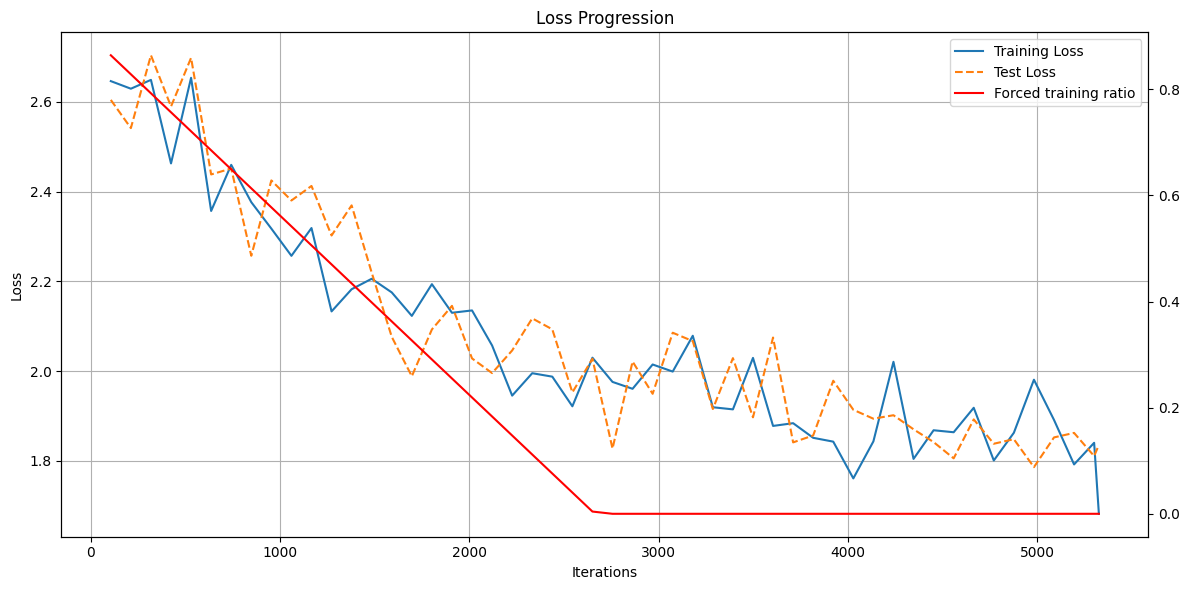

In [16]:
import matplotlib.pyplot as plt

# Create the figure and the primary y-axis
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

# Plot the loss on the primary y-axis
ax1.plot(iteration_values, train_loss_values, label='Training Loss')
ax1.plot(iteration_values, test_loss_values, label='Test Loss', linestyle='--')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Progression')
ax1.grid(True)
ax1.legend()

ax2 = ax1.twinx()

ax2.plot(iteration_values, ft_values, label='Forced training ratio', color="red")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

In [17]:
import nltk

def translate(sentence, max_output_length=20):
    tokens = [SOS_token] + nltk.word_tokenize(sentence) + [EOS_token]
    tokens, _ = model.evaluate(tokens, max_output_length)
    print(' '.join(tokens))

translate('Go!')
translate('It\'s not Fine.')
translate('I\'m very happy today.')
translate('He\'s very sad.')
translate('That man is wearing a white shirt.')
translate('He\'s very afraid of spiders.')
translate('He\'s going home to his wife.')
translate('Those guys are walking to work.')
translate('I\'m not going with you today.')
translate('My girlfriend will not come over tomorrow.')
translate('He bought his friends a present for christmas.')


<sos> Doe de de de '' '' '' '' <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<sos> Het is niet niet , , , . . . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<sos> Ik ben niet niet dat dat het het het . . . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<sos> Hij is de de van de de is . . . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<sos> Dat is is een een van een een een een . . . <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<sos> Hij is een enige van van , , , . . . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<sos> Hij zal de de de de de de . . . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<sos> Er <unk> <unk> de de de de . . . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<sos> Ik ben niet niet je je je je . . . . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<sos> Mijn zegt zal niet niet het het het het . . . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<sos> Hij heeft een een <unk> een <unk> zijn zij

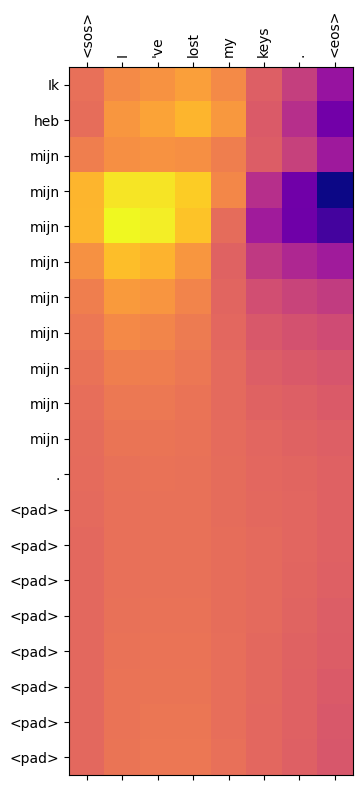

In [28]:
''' Sample a random sentence from the test data '''
input_tokens = test_data['ENG_TOKENS'].sample().iloc[0]

output_tokens, attentions = model.evaluate(input_tokens)
output_tokens = output_tokens[1:] # Remove single batch dimension
attentions = attentions.cpu().numpy()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(attentions, cmap='plasma')
fig.colorbar(cax).remove()
                
# Set up axes
ax.set_xticks(range(len(input_tokens)))
ax.set_yticks(range(len(output_tokens)))

ax.set_xticklabels(input_tokens, rotation=90)
ax.set_yticklabels(output_tokens)

plt.tight_layout()
plt.show()